# Car Price Prediction with SVR

## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease, mean_loss_decrease

## Import Data

In [2]:
df = pd.read_csv("data/carprice.csv", index_col="ID")
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price
ID,,,,,,,,,,,,
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74
6,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08,1461.0,63.10,5.0,3.50


# Exploratory Data Analysis (EDA)

## Target 

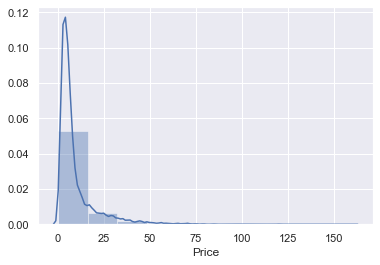

In [3]:
sns.distplot(df.Price, bins=10);

* Target variabel mengalami skewed positif.
* Price dengan frekuensi terbanyak berada pada rentang ± 0 - 23. 

## Statistik Deskriptif 

In [4]:
df.describe()

,Year,Kilometers_Driven,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price
count,5953.000000,5.953000e+03,5951.000000,5917.000000,5811.000000,5911.000000,5953.000000
mean,2013.356459,5.876729e+04,18.064325,1627.298293,113.803144,5.281509,9.547306
std,3.275069,9.174384e+04,4.511393,601.584633,53.896719,0.810628,11.230163
min,1998.000000,1.710000e+02,0.000000,72.000000,34.200000,0.000000,0.440000
25%,2011.000000,3.400000e+04,15.100000,1198.000000,78.000000,5.000000,3.500000
50%,2014.000000,5.300000e+04,18.120000,1495.000000,98.600000,5.000000,5.700000
75%,2016.000000,7.300000e+04,21.025000,1991.000000,139.010000,5.000000,10.000000
max,2019.000000,6.500000e+06,28.400000,5998.000000,560.000000,10.000000,160.000000


In [5]:
df.describe(include='O')

,Name,Location,Fuel_Type,Transmission,Owner_Type
count,5953,5953,5953,5953,5953
unique,1849,11,3,2,4
top,Mahindra XUV500 W8 2WD,Mumbai,Diesel,Manual,First
freq,49,772,3205,4233,4876


## Numeric

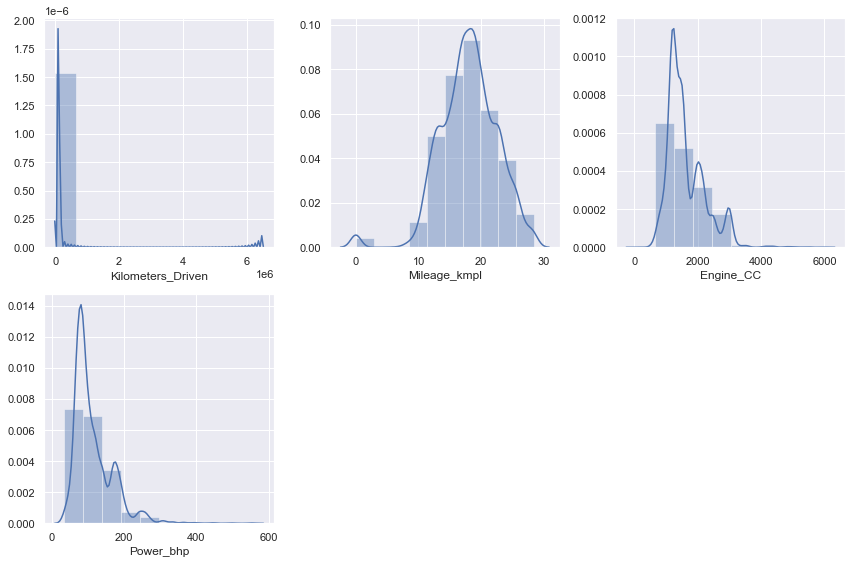

In [6]:
numeric = ['Kilometers_Driven','Mileage_kmpl','Engine_CC','Power_bhp']

a = plt.figure(figsize=(12, 8))

for i, j in enumerate(numeric):
    a.add_subplot(2, 3, i+1)
    sns.distplot(df[j], bins=10)
    a.tight_layout()

Dari visualisasi di atas dapat ditarik insight sebagai berikut :
* Kilometers_Driven sepertinya ada outlier nanti akan kita cek lebih lanjut. 
* Mileage_kmpl frekuensi terbanyak berada pada rentang ± 18. 
* Ada yang aneh pada Mileage_kmpl dimana ada nilai 0 ini juga akan kita cek lebih lanjut. 
* Engine_CC frekuensi terbanyak berada pada rentang ± 1000.
* Power_bhp frekuensi terbanyak berada pada rentang ± 100

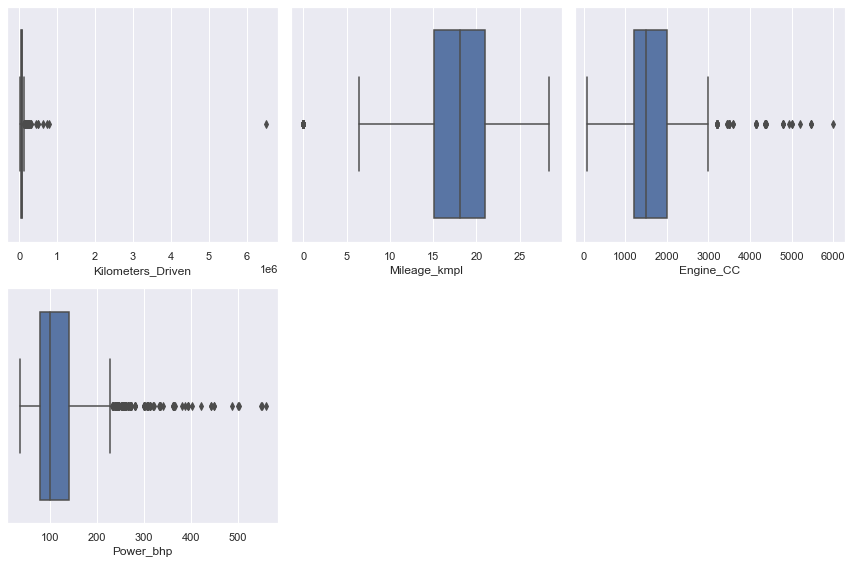

In [7]:
numeric = ['Kilometers_Driven','Mileage_kmpl','Engine_CC','Power_bhp']

a = plt.figure(figsize=(12, 8))

for i, j in enumerate(numeric):
    a.add_subplot(2, 3, i+1)
    sns.boxplot(df[j])
    a.tight_layout()

Sepertinya memang benar ada outlier pada Kilometers_Driven dan Mileage_kmpl.

In [8]:
df[df.Kilometers_Driven == 6500000]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price
ID,,,,,,,,,,,,
2328,BMW X5 xDrive 30d M Sport,Chennai,2017,6500000,Diesel,Automatic,First,15.97,2993.0,258.0,5.0,65.0


Menurut saya tidak masuk akal mobil tahun 2017 telah berjalan sejauh 6500000. Kalo kita ambil saja dari tahun terakhir di data ini (2019) berarti per-tahun mobil berjalan sejauh 3250000 dan lagi-lagi saya katakan ini tidak masuk akal. Menurut saya ini terjadi kesalahan penulisan. 

In [9]:
df[(df.Kilometers_Driven == 65000) & (df.Year == 2017)]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price
ID,,,,,,,,,,,,
2387,Maruti Ertiga VDI,Delhi,2017,65000,Diesel,Manual,First,25.47,1248.0,88.5,7.0,7.65
5279,Tata Zest Revotron 1.2T XE,Kolkata,2017,65000,Petrol,Manual,First,17.57,1193.0,88.7,5.0,4.80


Kilometers_Driven 65000 bagi saya masuk akal untuk mobil tahun 2017. Jadi saya akan mengganti 6500000 dengan 65000. 

In [10]:
df[df.Mileage_kmpl == 0]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price
ID,,,,,,,,,,,,
14,Land Rover Freelander 2 TD4 SE,Pune,2012,85000,Diesel,Automatic,Second,0.0,2179.0,115.0,5.0,17.50
67,Mercedes-Benz C-Class Progressive C 220d,Coimbatore,2019,15369,Diesel,Automatic,First,0.0,1950.0,194.0,5.0,35.67
79,Hyundai Santro Xing XL,Hyderabad,2005,87591,Petrol,Manual,First,0.0,1086.0,NaN,5.0,1.30
194,Honda City 1.5 GXI,Ahmedabad,2007,60006,Petrol,Manual,First,0.0,NaN,NaN,NaN,2.95
229,Ford Figo Diesel,Bangalore,2015,70436,Diesel,Manual,First,0.0,1498.0,99.0,NaN,3.60
...,...,...,...,...,...,...,...,...,...,...,...,...
5647,Toyota Qualis Fleet A3,Mumbai,2001,227000,Diesel,Manual,Fourth & Above,0.0,2446.0,NaN,8.0,2.20
5875,Mercedes-Benz C-Class Progressive C 220d,Ahmedabad,2019,4000,Diesel,Automatic,First,0.0,1950.0,194.0,5.0,35.00
5943,Mahindra Jeep MM 540 DP,Chennai,2002,75000,Diesel,Manual,First,0.0,2112.0,NaN,6.0,1.70


Ternyata ada 68 data yang memiliki Mileage_kmpl 0 lagi-lagi ini tidak masuk akal. Apakah ada mobil seboros itu ? Atau tangkinya bocor ? :)
Kalo seandainya terjadi kesalahan penulisan masa iya sebanyak ini, maka dari itu untuk saat ini saya biarkan saja data-data ini. Kalo memang sangat menggangu performa model mungkin akan saya pisahkan data-data ini agar bisa dianalisis secara terpisah. 

In [11]:
# replace 6500000 to 65000 
df.replace(6500000, 65000, inplace=True)

## Categoric

In [12]:
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price
ID,,,,,,,,,,,,
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74
6,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08,1461.0,63.10,5.0,3.50


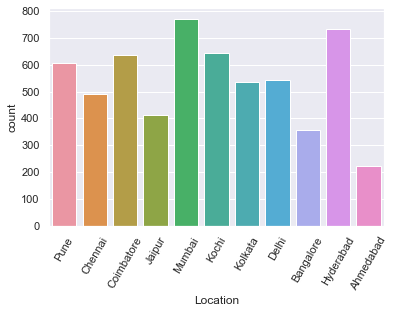

In [13]:
plot = sns.countplot(df.Location)
plt.setp(plot.get_xticklabels(), rotation=60);

Lokasi mobil paling banyak dari Mumbai walaupun tidak begitu signifikan. 

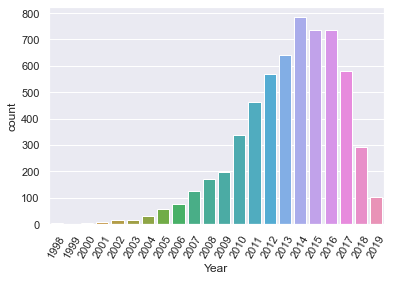

In [14]:
plot = sns.countplot(df.Year)
plt.setp(plot.get_xticklabels(), rotation=60);

Paling banyak ternyata mobil tahun 2014 walaupun tidak begitu signifikan. 

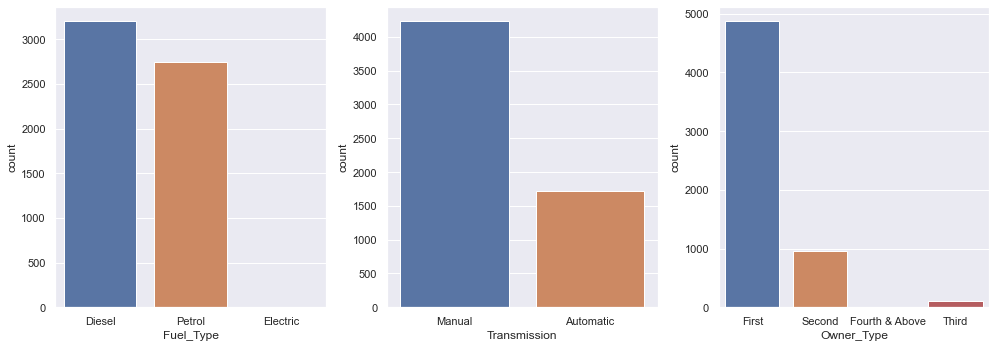

In [15]:
categoric = ['Fuel_Type','Transmission','Owner_Type']

b = plt.figure(figsize=(14, 5))

for i, j in enumerate(categoric):
    b.add_subplot(1, 3, i+1)
    sns.countplot(df[j])
    b.tight_layout()

Dari visualisasi di atas dapat ditarik insight sebagai berikut : 
* Fuel_Type diesel dan petrol memiliki frekuensi tertinggi dengan perbedaan yang tidak begitu signifikan. 
* Transmission manual memiliki frekuensi tertinggi dengan perbedaan yang signifikan. 
* Owner_Type first memiliki frekuensi tertinggi dengan perbedaan yang sangat signifikan. 

## Korelasi 

In [16]:
from jcopml.plot import plot_correlation_matrix

In [17]:
plot_correlation_matrix(df, 'Price')

interactive(children=(ToggleButtons(description='method', options=('spearman', 'kendall', 'pearson', 'pearson_…

Power_bhp dan Engine_CC memiliki korelasi positif kuat dengan price.

## Add New Features 

### Make 

In [18]:
df['Make'] = df.Name.apply(lambda x: x.split(' ')[0])
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price,Make
ID,,,,,,,,,,,,,
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50,Hyundai
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50,Honda
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00,Maruti
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74,Audi
6,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08,1461.0,63.10,5.0,3.50,Nissan


In [19]:
df.Make.value_counts()

Maruti           1157
Hyundai          1098
Honda             608
Toyota            410
Mercedes-Benz     318
Volkswagen        315
Ford              300
Mahindra          272
BMW               267
Audi              236
Tata              184
Skoda             173
Renault           145
Chevrolet         121
Nissan             91
Land               60
Jaguar             40
Fiat               28
Mitsubishi         27
Mini               26
Volvo              21
Porsche            18
Jeep               15
Datsun             13
Force               3
ISUZU               2
Bentley             1
Ambassador          1
Lamborghini         1
Smart               1
Isuzu               1
Name: Make, dtype: int64

ISUZU dan Isuzu seharusnya sama. 

In [20]:
df.Make.replace('ISUZU', 'Isuzu', inplace=True)

In [21]:
df.Make.value_counts()

Maruti           1157
Hyundai          1098
Honda             608
Toyota            410
Mercedes-Benz     318
Volkswagen        315
Ford              300
Mahindra          272
BMW               267
Audi              236
Tata              184
Skoda             173
Renault           145
Chevrolet         121
Nissan             91
Land               60
Jaguar             40
Fiat               28
Mitsubishi         27
Mini               26
Volvo              21
Porsche            18
Jeep               15
Datsun             13
Isuzu               3
Force               3
Lamborghini         1
Smart               1
Bentley             1
Ambassador          1
Name: Make, dtype: int64

In [22]:
df.drop(columns='Name', axis=1, inplace=True)
df.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price,Make
ID,,,,,,,,,,,,
1,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50,Hyundai
2,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50,Honda
3,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00,Maruti
4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74,Audi
6,Jaipur,2013,86999,Diesel,Manual,First,23.08,1461.0,63.10,5.0,3.50,Nissan


## Dataset Splitting

In [23]:
X = df.drop(columns="Price")
y = df.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4762, 11), (1191, 11), (4762,), (1191,))

## Modeling 

In [24]:
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp
from sklearn.svm import SVR

In [25]:
gsp.svm_params

{'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [26]:
X_train.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Make
ID,,,,,,,,,,,
4380,Coimbatore,2016,60913,Petrol,Manual,First,20.73,1373.0,91.1,5.0,Maruti
2676,Kochi,2017,40459,Diesel,Manual,First,19.67,1582.0,126.2,5.0,Hyundai
647,Jaipur,2004,200000,Petrol,Manual,First,0.00,1086.0,NaN,5.0,Hyundai
5966,Hyderabad,2018,1048,Petrol,Manual,First,18.90,998.0,67.1,5.0,Maruti
2198,Ahmedabad,2013,96000,Diesel,Manual,Second,23.50,1498.0,90.0,5.0,Ford


In [27]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), ['Year','Kilometers_Driven','Mileage_kmpl','Engine_CC','Power_bhp','Seats']),
    ('categoric', cat_pipe(encoder='onehot'), ['Location','Fuel_Type','Transmission','Owner_Type','Make']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])


model = GridSearchCV(pipeline, gsp.svm_params, cv=10, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 10 folds for each of 49 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed:  2.2min finished


{'algo__C': 10.0, 'algo__gamma': 0.1}
0.9068354307595832 0.8771460165913771 0.8728350551262056


Ternyata setelah dilakukan penambahan fitur baru terjadi kenaikan skor yang cukup signifikan pada train, val dan test sebesar ± 4%. 

## Features Important

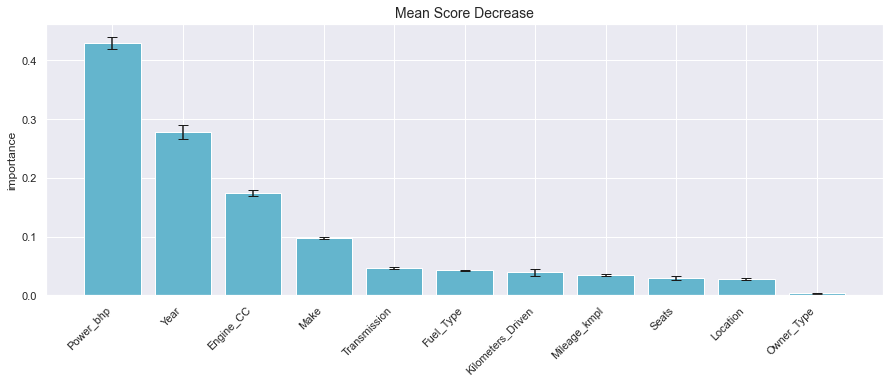

In [28]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True)

Power_bhp merupakan fitur paling penting dalam memprediksi harga mobil. 

## Polynomial Features 

In [29]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', poly=2), ['Year','Kilometers_Driven','Mileage_kmpl','Engine_CC','Power_bhp','Seats']),
    ('categoric', cat_pipe(encoder='onehot'), ['Location','Fuel_Type','Transmission','Owner_Type','Make']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])


model = GridSearchCV(pipeline, gsp.svm_params, cv=10, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 10 folds for each of 49 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed:  3.0min finished


{'algo__C': 100.0, 'algo__gamma': 0.01}
0.7596418991875121 0.8483117218680943 0.708982245637533


Setelah dilakukan polynomial features terjadi penurunan yang sangat signifikan pada train dan test. 

## Fine Tuning 

In [30]:
gsp.svm_params

{'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [31]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), ['Year','Kilometers_Driven','Mileage_kmpl','Engine_CC','Power_bhp','Seats']),
    ('categoric', cat_pipe(encoder='onehot'), ['Location','Fuel_Type','Transmission','Owner_Type','Make']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])


parameter = {'algo__gamma': [0.1, 0.2, 0.3],
             'algo__C': [10, 11]}


model = GridSearchCV(pipeline, parameter, cv=10, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   13.1s finished


{'algo__C': 11, 'algo__gamma': 0.1}
0.9134779138066724 0.8782181668420435 0.8754390040227632


Setelah dilakukan fine tuning terjadi sedikit kenaikan skor pada train, val dan test. 

## Evaluasi 

In [32]:
from jcopml.plot import plot_residual
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [33]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [34]:
print('MAE Train :', mean_absolute_error(y_train, y_pred_train))
print('MSE Train :', mean_squared_error(y_train, y_pred_train))
print('RMSE Train :', mean_squared_error(y_train, y_pred_train, squared=False))

MAE Train : 1.4964249181698737
MSE Train : 10.60581580844
RMSE Train : 3.2566571524248604


In [35]:
print('MAE Test :', mean_absolute_error(y_test, y_pred_test))
print('MSE Test :', mean_squared_error(y_test, y_pred_test))
print('RMSE Test :', mean_squared_error(y_test, y_pred_test, squared=False))

MAE Test : 1.7942427821636067
MSE Test : 17.457516398444273
RMSE Test : 4.178219285586178


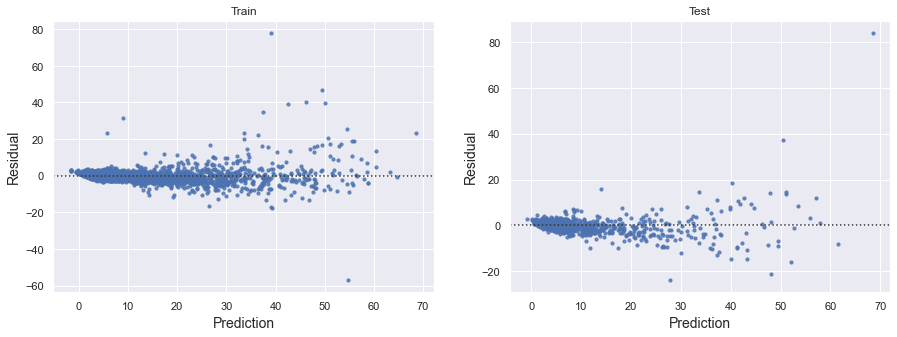

In [36]:
plot_residual(X_train, y_train, X_test, y_test, model)

Dari residual plot di atas memang terlihat lebih baik dari sebelumnya namun, saya melihat masih terjadi kekurangan informasi. 

## Coba cek datanya!

In [37]:
df_analisis = X_train.copy()
df_analisis['actual'] = y_train.copy()
df_analisis['pred'] = model.predict(X_train)
df_analisis['error'] = np.abs(df_analisis.actual - df_analisis.pred)
df_analisis.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Make,actual,pred,error
ID,,,,,,,,,,,,,,
4380,Coimbatore,2016,60913,Petrol,Manual,First,20.73,1373.0,91.1,5.0,Maruti,7.19,6.128730,1.061270
2676,Kochi,2017,40459,Diesel,Manual,First,19.67,1582.0,126.2,5.0,Hyundai,13.28,10.654589,2.625411
647,Jaipur,2004,200000,Petrol,Manual,First,0.00,1086.0,NaN,5.0,Hyundai,0.80,-0.065793,0.865793
5966,Hyderabad,2018,1048,Petrol,Manual,First,18.90,998.0,67.1,5.0,Maruti,4.70,4.476633,0.223367
2198,Ahmedabad,2013,96000,Diesel,Manual,Second,23.50,1498.0,90.0,5.0,Ford,3.50,3.713167,0.213167


In [38]:
df_analisis.sort_values('error', ascending=False).head(20)

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Make,actual,pred,error
ID,,,,,,,,,,,,,,
5781,Delhi,2011,6500,Petrol,Automatic,Third,6.40,5204.0,560.00,2.0,Lamborghini,120.00,39.162145,80.837855
3132,Kochi,2019,14298,Petrol,Automatic,First,13.33,2995.0,340.00,5.0,Porsche,2.02,54.787327,52.767327
5919,Hyderabad,2015,8000,Petrol,Automatic,First,12.50,5000.0,488.10,2.0,Jaguar,100.00,49.371143,50.628857
4691,Bangalore,2014,3000,Petrol,Automatic,Second,12.00,5461.0,421.00,2.0,Mercedes-Benz,90.00,46.133761,43.866239
1974,Coimbatore,2018,28060,Petrol,Automatic,First,12.05,2979.0,320.00,5.0,BMW,93.67,50.005301,43.664699
5535,Ahmedabad,2015,97003,Diesel,Automatic,First,15.87,2993.0,308.43,5.0,BMW,85.00,42.610827,42.389173
655,Mumbai,2017,10501,Petrol,Automatic,First,9.43,1999.0,237.40,5.0,Jaguar,75.00,37.484323,37.515677
1460,Coimbatore,2008,69078,Petrol,Manual,First,0.00,NaN,NaN,NaN,Land,40.88,8.952539,31.927461
2095,Coimbatore,2019,2526,Petrol,Automatic,First,19.00,2996.0,362.07,2.0,Mercedes-Benz,83.96,54.510843,29.449157


Masih seperti sebelumnya model kurang baik dalam memprediksi mobil-mobil dengan harga tinggi. Mobil dengan harga 120 malah errornya membesar walaupun yang lainnya mengalami penurunan error. 


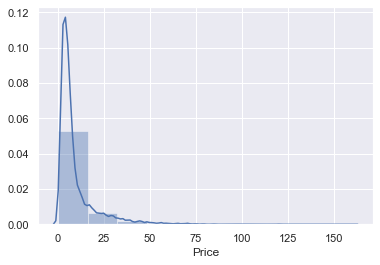

In [39]:
sns.distplot(df.Price, bins=10);

Entah kenapa saya merasa ini yang sepertinya menjadi masalah karena target variabel skew positif. Saya berpikir karena frekuensi terbanyak harga mobil berada pada rentang ± 0 - 23. Sehingga model memprediksi ke mayoritas frekuensi tersebut sementara ada juga mobil yang memiliki harga tinggi. Saya akan coba melakukan transformasi pada target variabel agar menjadi normal dan melakukan training lagi dengan harapan model akan lebih baik. 

## Save Model

In [40]:
save_model(model.best_estimator_, "CarPrice_v2.pkl")

Model is pickled as model/CarPrice_v2.pkl


# Transformasi Target Variabel 

In [41]:
y_train_trans = np.log10(y_train)

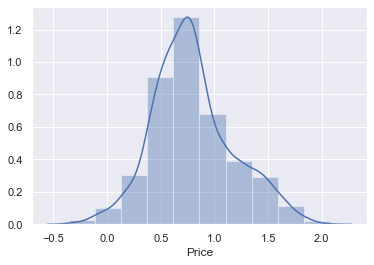

In [42]:
sns.distplot(y_train_trans, bins=10);

In [43]:
y_test_trans = np.log10(y_test)

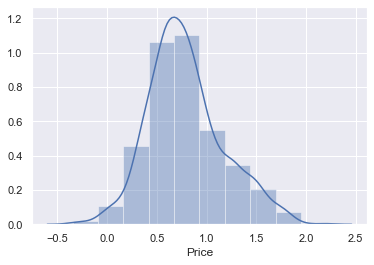

In [44]:
sns.distplot(y_test_trans, bins=10);

Setelah dilakukan transformasi data terlihat lebih normal.

## Modeling

In [45]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), ['Year','Kilometers_Driven','Mileage_kmpl','Engine_CC','Power_bhp','Seats']),
    ('categoric', cat_pipe(encoder='onehot'), ['Location','Fuel_Type','Transmission','Owner_Type','Make']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])


model = GridSearchCV(pipeline, gsp.svm_params, cv=10, n_jobs=-1, verbose=1)
model.fit(X_train, y_train_trans)

print(model.best_params_)
print(model.score(X_train, y_train_trans), model.best_score_, model.score(X_test, y_test_trans))

Fitting 10 folds for each of 49 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed:  2.1min finished


{'algo__C': 1.0, 'algo__gamma': 0.1}
0.956280839891581 0.9358471876636433 0.9343801803780415


Wow, terjadi peningkatan skor yang sangat signifikan! tapi, jangan senang dulu jelas saja skor meningkat alias error mengecil karena nilai dari target variabel menjadi lebih kecil setelah dilakukan transformasi. Pada akhirnya saya akan melakukan cek data sebagai pembanding agar lebih yakin.

## Features Important 

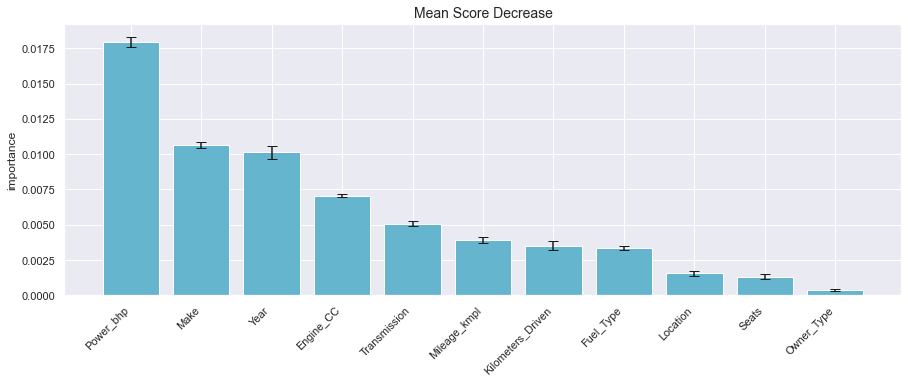

In [46]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True)

Power_bhp masih menjadi fitur yang paling penting dalam memprediksi harga mobil.

## Polynomial Features 

In [47]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust', poly=2), ['Year','Kilometers_Driven','Mileage_kmpl','Engine_CC','Power_bhp','Seats']),
    ('categoric', cat_pipe(encoder='onehot'), ['Location','Fuel_Type','Transmission','Owner_Type','Make']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])


model = GridSearchCV(pipeline, gsp.svm_params, cv=10, n_jobs=-1, verbose=1)
model.fit(X_train, y_train_trans)

print(model.best_params_)
print(model.score(X_train, y_train_trans), model.best_score_, model.score(X_test, y_test_trans))

Fitting 10 folds for each of 49 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed:  3.0min finished


{'algo__C': 1.0, 'algo__gamma': 0.01}
0.9348231342363644 0.9168661485007059 0.9205822017297667


Terjadi penurunan skor pada train, val dan test setelah dilakukan polynomial features. 

## Fine Tuning 

In [48]:
gsp.svm_params

{'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [49]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), ['Year','Kilometers_Driven','Mileage_kmpl','Engine_CC','Power_bhp','Seats']),
    ('categoric', cat_pipe(encoder='onehot'), ['Location','Fuel_Type','Transmission','Owner_Type','Make']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])


parameter = {'algo__gamma': [0.1, 0.2, 0.3],
             'algo__C': [1, 2, 3]}


model = GridSearchCV(pipeline, parameter, cv=10, n_jobs=-1, verbose=1)
model.fit(X_train, y_train_trans)

print(model.best_params_)
print(model.score(X_train, y_train_trans), model.best_score_, model.score(X_test, y_test_trans))

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.5s finished


{'algo__C': 1, 'algo__gamma': 0.1}
0.956280839891581 0.9358471876636433 0.9343801803780415


Setelah dilakukan fine tuning, tidak terjadi perubahan skor yang berarti kita telah mendapatkan hyperparameter yang optimal.

## Evaluasi 

In [50]:
y_pred_train = np.power(10, model.predict(X_train))
y_pred_test = np.power(10, model.predict(X_test))

In [51]:
print('MAE Train :', mean_absolute_error(y_train, y_pred_train))
print('MSE Train :', mean_squared_error(y_train, y_pred_train))
print('RMSE Train :', mean_squared_error(y_train, y_pred_train, squared=False))

MAE Train : 1.369118998083558
MSE Train : 6.755154181125139
RMSE Train : 2.599067944691931


In [52]:
print('MAE Test :', mean_absolute_error(y_test, y_pred_test))
print('MSE Test :', mean_squared_error(y_test, y_pred_test))
print('RMSE Test :', mean_squared_error(y_test, y_pred_test, squared=False))

MAE Test : 1.6393520154438994
MSE Test : 14.550456545489274
RMSE Test : 3.81450606835135


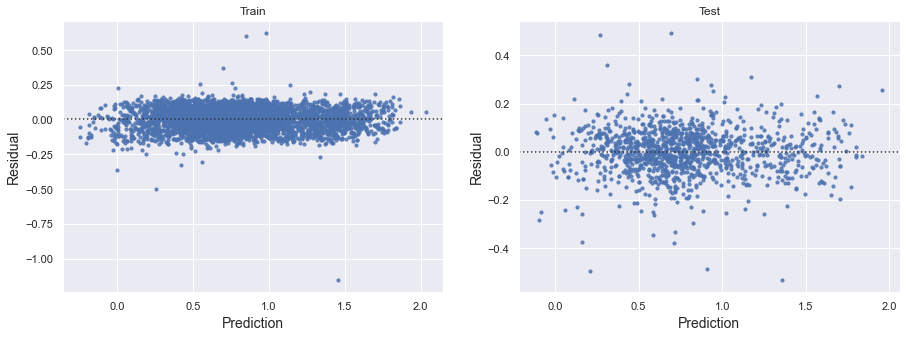

In [53]:
plot_residual(X_train, y_train_trans, X_test, y_test_trans, model)

## Coba cek datanya!

In [54]:
df_analisis = X_train.copy()
df_analisis['actual'] = y_train_trans.copy()
df_analisis['pred'] = model.predict(X_train)
df_analisis['error'] = np.abs(df_analisis.actual - df_analisis.pred)
df_analisis['actual_real'] = y_train.copy()
df_analisis['pred_real'] = np.power(10, model.predict(X_train))
df_analisis['error_real'] = np.abs(df_analisis.actual_real - df_analisis.pred_real)
df_analisis.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Make,actual,pred,error,actual_real,pred_real,error_real
ID,,,,,,,,,,,,,,,,,
4380,Coimbatore,2016,60913,Petrol,Manual,First,20.73,1373.0,91.1,5.0,Maruti,0.856729,0.817179,0.039550,7.19,6.564163,0.625837
2676,Kochi,2017,40459,Diesel,Manual,First,19.67,1582.0,126.2,5.0,Hyundai,1.123198,0.998961,0.124237,13.28,9.976103,3.303897
647,Jaipur,2004,200000,Petrol,Manual,First,0.00,1086.0,NaN,5.0,Hyundai,-0.096910,-0.010588,0.086322,0.80,0.975914,0.175914
5966,Hyderabad,2018,1048,Petrol,Manual,First,18.90,998.0,67.1,5.0,Maruti,0.672098,0.675731,0.003633,4.70,4.739487,0.039487
2198,Ahmedabad,2013,96000,Diesel,Manual,Second,23.50,1498.0,90.0,5.0,Ford,0.544068,0.584801,0.040733,3.50,3.844153,0.344153


In [55]:
df_analisis.sort_values('error_real', ascending=False).head(20)

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Make,actual,pred,error,actual_real,pred_real,error_real
ID,,,,,,,,,,,,,,,,,
1460,Coimbatore,2008,69078,Petrol,Manual,First,0.00,NaN,NaN,NaN,Land,1.611511,0.982238,0.629273,40.88,9.599268,31.280732
1974,Coimbatore,2018,28060,Petrol,Automatic,First,12.05,2979.0,320.00,5.0,BMW,1.971601,1.815833,0.155768,93.67,65.438379,28.231621
5919,Hyderabad,2015,8000,Petrol,Automatic,First,12.50,5000.0,488.10,2.0,Jaguar,2.000000,1.858504,0.141496,100.00,72.194415,27.805585
3132,Kochi,2019,14298,Petrol,Automatic,First,13.33,2995.0,340.00,5.0,Porsche,0.305351,1.457998,1.152647,2.02,28.707674,26.687674
655,Mumbai,2017,10501,Petrol,Automatic,First,9.43,1999.0,237.40,5.0,Jaguar,1.875061,1.696236,0.178825,75.00,49.686265,25.313735
5535,Ahmedabad,2015,97003,Diesel,Automatic,First,15.87,2993.0,308.43,5.0,BMW,1.929419,1.797579,0.131840,85.00,62.744993,22.255007
5075,Kolkata,2007,43627,Petrol,Automatic,First,11.74,1796.0,186.00,5.0,Mercedes-Benz,1.462398,0.851498,0.610900,29.00,7.103918,21.896082
1885,Delhi,2018,6000,Diesel,Automatic,First,11.00,2987.0,258.00,7.0,Mercedes-Benz,1.897627,1.771827,0.125800,79.00,59.132586,19.867414
2095,Coimbatore,2019,2526,Petrol,Automatic,First,19.00,2996.0,362.07,2.0,Mercedes-Benz,1.924072,1.813557,0.110515,83.96,65.096465,18.863535


Setelah dilakukan transformasi target variabel terjadi penurunan error real yang sangat signifikan sebesar 49.557123 sebelumnya error paling besar 80.837855 menjadi 31.280732. 

In [56]:
df_analisis[df_analisis.Make == 'Lamborghini']

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Make,actual,pred,error,actual_real,pred_real,error_real
ID,,,,,,,,,,,,,,,,,
5781,Delhi,2011,6500,Petrol,Automatic,Third,6.4,5204.0,560.0,2.0,Lamborghini,2.079181,2.032415,0.046766,120.0,107.749402,12.250598


Error real pada Lamborghini pun berhasil dikecilkan :)

## Save Model

In [57]:
save_model(model.best_estimator_, "CarPrice_v3.pkl")

Model is pickled as model/CarPrice_v3.pkl


# Try Binning 

In [58]:
df.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price,Make
ID,,,,,,,,,,,,
1,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50,Hyundai
2,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50,Honda
3,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00,Maruti
4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74,Audi
6,Jaipur,2013,86999,Diesel,Manual,First,23.08,1461.0,63.10,5.0,3.50,Nissan


## Binning Kilometers_Driven

In [59]:
df.Kilometers_Driven = pd.cut(df.Kilometers_Driven, bins=3, labels=['low','medium','high'])
df.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price,Make
ID,,,,,,,,,,,,
1,Pune,2015,low,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50,Hyundai
2,Chennai,2011,low,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50,Honda
3,Chennai,2012,low,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00,Maruti
4,Coimbatore,2013,low,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74,Audi
6,Jaipur,2013,low,Diesel,Manual,First,23.08,1461.0,63.10,5.0,3.50,Nissan


## Binning Mileage_kmpl

In [60]:
df.Mileage_kmpl = pd.cut(df.Mileage_kmpl, bins=3, labels=['boros','sedang','irit'])
df.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price,Make
ID,,,,,,,,,,,,
1,Pune,2015,low,Diesel,Manual,First,irit,1582.0,126.20,5.0,12.50,Hyundai
2,Chennai,2011,low,Petrol,Manual,First,sedang,1199.0,88.70,5.0,4.50,Honda
3,Chennai,2012,low,Diesel,Manual,First,irit,1248.0,88.76,7.0,6.00,Maruti
4,Coimbatore,2013,low,Diesel,Automatic,Second,sedang,1968.0,140.80,5.0,17.74,Audi
6,Jaipur,2013,low,Diesel,Manual,First,irit,1461.0,63.10,5.0,3.50,Nissan


## Binning Engine_CC

In [61]:
df.Engine_CC = pd.cut(df.Engine_CC, bins=3, labels=['low','medium','high'])
df.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price,Make
ID,,,,,,,,,,,,
1,Pune,2015,low,Diesel,Manual,First,irit,low,126.20,5.0,12.50,Hyundai
2,Chennai,2011,low,Petrol,Manual,First,sedang,low,88.70,5.0,4.50,Honda
3,Chennai,2012,low,Diesel,Manual,First,irit,low,88.76,7.0,6.00,Maruti
4,Coimbatore,2013,low,Diesel,Automatic,Second,sedang,low,140.80,5.0,17.74,Audi
6,Jaipur,2013,low,Diesel,Manual,First,irit,low,63.10,5.0,3.50,Nissan


## Binning Power_bhp 

In [62]:
df.Power_bhp = pd.cut(df.Power_bhp, bins=3, labels=['low','medium','high'])
df.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price,Make
ID,,,,,,,,,,,,
1,Pune,2015,low,Diesel,Manual,First,irit,low,low,5.0,12.50,Hyundai
2,Chennai,2011,low,Petrol,Manual,First,sedang,low,low,5.0,4.50,Honda
3,Chennai,2012,low,Diesel,Manual,First,irit,low,low,7.0,6.00,Maruti
4,Coimbatore,2013,low,Diesel,Automatic,Second,sedang,low,low,5.0,17.74,Audi
6,Jaipur,2013,low,Diesel,Manual,First,irit,low,low,5.0,3.50,Nissan


## Dataset Splitting 

In [63]:
X = df.drop(columns="Price")
y = df.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4762, 11), (1191, 11), (4762,), (1191,))

## Modeling 

In [64]:
gsp.svm_params

{'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [65]:
X_train.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Make
ID,,,,,,,,,,,
4380,Coimbatore,2016,low,Petrol,Manual,First,irit,low,low,5.0,Maruti
2676,Kochi,2017,low,Diesel,Manual,First,irit,low,low,5.0,Hyundai
647,Jaipur,2004,low,Petrol,Manual,First,boros,low,NaN,5.0,Hyundai
5966,Hyderabad,2018,low,Petrol,Manual,First,sedang,low,low,5.0,Maruti
2198,Ahmedabad,2013,low,Diesel,Manual,Second,irit,low,low,5.0,Ford


In [66]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), ['Year','Seats']),
    ('categoric', cat_pipe(encoder='onehot'), ['Location','Kilometers_Driven','Fuel_Type','Transmission',
                                                'Owner_Type','Mileage_kmpl','Engine_CC', 'Power_bhp','Make']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])


model = GridSearchCV(pipeline, gsp.svm_params, cv=10, n_jobs=-1, verbose=1)
model.fit(X_train, y_train_trans)

print(model.best_params_)
print(model.score(X_train, y_train_trans), model.best_score_, model.score(X_test, y_test_trans))

Fitting 10 folds for each of 49 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed:  2.4min finished


{'algo__C': 1.0, 'algo__gamma': 0.1}
0.9128418829582726 0.8855807819756233 0.8942069617513745


Setelah dilakukan binning ternyata terjadi penurunan skor pada train, val dan test

## Features Important 

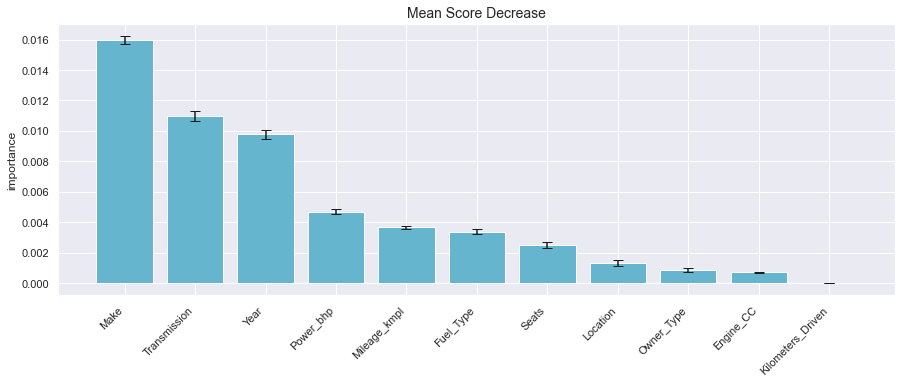

In [67]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True)

Setelah dilakukan binning fitur make menjadi fitur paling penting dalam memprediksi harga mobil.

In [68]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), ['Year','Seats']),
    ('categoric', cat_pipe(encoder='onehot'), ['Location','Fuel_Type','Transmission','Owner_Type',
                                               'Mileage_kmpl','Engine_CC','Power_bhp','Make']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])


model = GridSearchCV(pipeline, gsp.svm_params, cv=10, n_jobs=-1, verbose=1)
model.fit(X_train, y_train_trans)

print(model.best_params_)
print(model.score(X_train, y_train_trans), model.best_score_, model.score(X_test, y_test_trans))

Fitting 10 folds for each of 49 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed:  2.3min finished


{'algo__C': 1.0, 'algo__gamma': 0.1}
0.9129238910347363 0.889004790274529 0.8941933804701259


Setelah fitur Kilometers_Driven dihapus terjadi sedikit kenaikan pada train, val dan sedikit penurunan pada test.

## Polynomial Features

In [69]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', poly=2), ['Year','Seats']),
    ('categoric', cat_pipe(encoder='onehot'), ['Location','Fuel_Type','Transmission','Owner_Type',
                                               'Mileage_kmpl','Engine_CC','Power_bhp','Make']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])


model = GridSearchCV(pipeline, gsp.svm_params, cv=10, n_jobs=-1, verbose=1)
model.fit(X_train, y_train_trans)

print(model.best_params_)
print(model.score(X_train, y_train_trans), model.best_score_, model.score(X_test, y_test_trans))

Fitting 10 folds for each of 49 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed:  2.4min finished


{'algo__C': 1.0, 'algo__gamma': 0.1}
0.9078096256044559 0.880419115350786 0.8871244162917413


Setelah dilakukan polynomial features terjadi penurunan skor pada train, val dan test. 

## Fine Tuning 

In [70]:
gsp.svm_params

{'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [71]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), ['Year','Seats']),
    ('categoric', cat_pipe(encoder='onehot'), ['Location','Fuel_Type','Transmission','Owner_Type',
                                               'Mileage_kmpl','Engine_CC','Power_bhp','Make']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])


parameter = {'algo__gamma': [0.1, 0.2, 0.3],
             'algo__C': [1, 2, 3]}


model = GridSearchCV(pipeline, parameter, cv=10, n_jobs=-1, verbose=1)
model.fit(X_train, y_train_trans)

print(model.best_params_)
print(model.score(X_train, y_train_trans), model.best_score_, model.score(X_test, y_test_trans))

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   18.7s finished


{'algo__C': 1, 'algo__gamma': 0.1}
0.9129238910347363 0.889004790274529 0.8941933804701259


Setelah dilakukan fine tuning, kita telah mendapatkan hyperparameter yang optimal.

## Evaluasi 

In [72]:
y_pred_train = np.power(10, model.predict(X_train))
y_pred_test = np.power(10, model.predict(X_test))

In [73]:
print('MAE Train :', mean_absolute_error(y_train, y_pred_train))
print('MSE Train :', mean_squared_error(y_train, y_pred_train))
print('RMSE Train :', mean_squared_error(y_train, y_pred_train, squared=False))

MAE Train : 1.9791013494864749
MSE Train : 13.371966538431394
RMSE Train : 3.656769959736515


In [74]:
print('MAE Test :', mean_absolute_error(y_test, y_pred_test))
print('MSE Test :', mean_squared_error(y_test, y_pred_test))
print('RMSE Test :', mean_squared_error(y_test, y_pred_test, squared=False))

MAE Test : 2.1454695063901705
MSE Test : 20.89168211315772
RMSE Test : 4.570741965278473


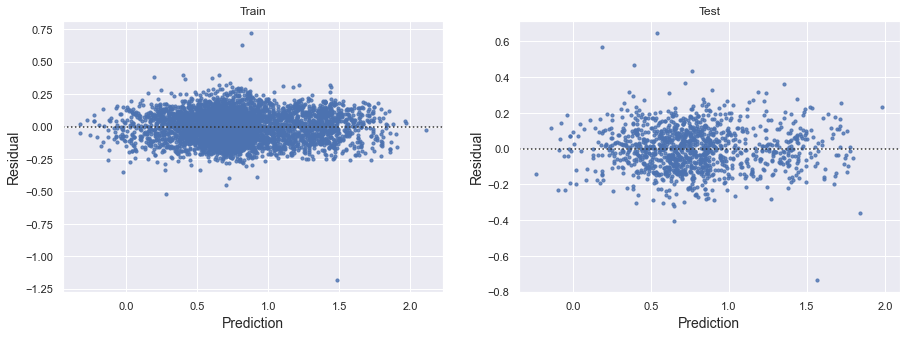

In [75]:
plot_residual(X_train, y_train_trans, X_test, y_test_trans, model)

Setelah dilakukan binning pada residual plot di atas saya melihat ada pola kekurangan informasi pada train dan test. Model tanpa binning memiliki residual plot lebih baik.

In [76]:
df_analisis = X_train.copy()
df_analisis['actual'] = y_train_trans.copy()
df_analisis['pred'] = model.predict(X_train)
df_analisis['error'] = np.abs(df_analisis.actual - df_analisis.pred)
df_analisis['actual_real'] = y_train.copy()
df_analisis['pred_real'] = np.power(10, model.predict(X_train))
df_analisis['error_real'] = np.abs(df_analisis.actual_real - df_analisis.pred_real)
df_analisis.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Make,actual,pred,error,actual_real,pred_real,error_real
ID,,,,,,,,,,,,,,,,,
4380,Coimbatore,2016,low,Petrol,Manual,First,irit,low,low,5.0,Maruti,0.856729,0.766384,0.090345,7.19,5.839607,1.350393
2676,Kochi,2017,low,Diesel,Manual,First,irit,low,low,5.0,Hyundai,1.123198,0.850306,0.272892,13.28,7.084443,6.195557
647,Jaipur,2004,low,Petrol,Manual,First,boros,low,NaN,5.0,Hyundai,-0.096910,-0.040809,0.056101,0.80,0.910314,0.110314
5966,Hyderabad,2018,low,Petrol,Manual,First,sedang,low,low,5.0,Maruti,0.672098,0.663856,0.008242,4.70,4.611649,0.088351
2198,Ahmedabad,2013,low,Diesel,Manual,Second,irit,low,low,5.0,Ford,0.544068,0.579957,0.035889,3.50,3.801518,0.301518


In [77]:
df_analisis.sort_values('error_real', ascending=False).head(20)

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Make,actual,pred,error,actual_real,pred_real,error_real
ID,,,,,,,,,,,,,,,,,
1460,Coimbatore,2008,low,Petrol,Manual,First,boros,NaN,NaN,NaN,Land,1.611511,0.879334,0.732177,40.88,7.574157,33.305843
4691,Bangalore,2014,low,Petrol,Automatic,Second,sedang,high,high,2.0,Mercedes-Benz,1.954243,1.774067,0.180176,90.00,59.438348,30.561652
2111,Kochi,2017,low,Diesel,Automatic,First,sedang,medium,low,5.0,Mercedes-Benz,1.753813,1.433128,0.320685,56.73,27.109885,29.620115
3132,Kochi,2019,low,Petrol,Automatic,First,sedang,medium,medium,5.0,Porsche,0.305351,1.484995,1.179643,2.02,30.548826,28.528826
802,Mumbai,2016,low,Diesel,Automatic,First,sedang,medium,low,5.0,Mercedes-Benz,1.748188,1.442265,0.305923,56.00,27.686336,28.313664
271,Coimbatore,2017,low,Diesel,Automatic,First,sedang,medium,medium,5.0,BMW,1.660581,1.858511,0.197930,45.77,72.195619,26.425619
5603,Delhi,2013,low,Diesel,Automatic,First,boros,high,high,4.0,Porsche,1.857332,1.667505,0.189827,72.00,46.505605,25.494395
2528,Delhi,2016,low,Diesel,Automatic,First,sedang,medium,medium,7.0,Land,1.565257,1.793528,0.228270,36.75,62.162406,25.412406
1583,Kochi,2019,low,Diesel,Automatic,First,sedang,medium,medium,7.0,Audi,1.862966,1.679070,0.183896,72.94,47.760570,25.179430


Dari segi error real pun model tanpa binning masih lebih baik walaupun hanya selisih ± 2%.

## Save Model

In [78]:
X_train.drop(columns='Kilometers_Driven', axis=1, inplace=True)
X_train.head()

,Location,Year,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Make
ID,,,,,,,,,,
4380,Coimbatore,2016,Petrol,Manual,First,irit,low,low,5.0,Maruti
2676,Kochi,2017,Diesel,Manual,First,irit,low,low,5.0,Hyundai
647,Jaipur,2004,Petrol,Manual,First,boros,low,NaN,5.0,Hyundai
5966,Hyderabad,2018,Petrol,Manual,First,sedang,low,low,5.0,Maruti
2198,Ahmedabad,2013,Diesel,Manual,Second,irit,low,low,5.0,Ford


In [79]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), ['Year','Seats']),
    ('categoric', cat_pipe(encoder='onehot'), ['Location','Fuel_Type','Transmission','Owner_Type',
                                               'Mileage_kmpl','Engine_CC','Power_bhp','Make']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])


parameter = {'algo__gamma': [0.1, 0.2, 0.3],
             'algo__C': [1, 2, 3]}


model = GridSearchCV(pipeline, parameter, cv=10, n_jobs=-1, verbose=1)
model.fit(X_train, y_train_trans)

print(model.best_params_)
print(model.score(X_train, y_train_trans), model.best_score_, model.score(X_test, y_test_trans))

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   18.7s finished


{'algo__C': 1, 'algo__gamma': 0.1}
0.9129238910347363 0.889004790274529 0.8941933804701259


In [80]:
save_model(model.best_estimator_, "CarPrice_v4.pkl")

Model is pickled as model/CarPrice_v4.pkl


## Load Model
Kita akan load model terbaik (CarPrice_v3.pkl) dan melakukan prediksi data baru.

In [81]:
model = load_model('model/CarPrice_v3.pkl')

In [82]:
df_new = [['Jaipur', 2012, 12000, 'Diesel', 'Manual', 'Second', 19, 1000, 80, 5, 'Nissan'], 
         ['Hyderabad', 2015, 8000, 'Petrol', 'Automatic', 'First', 12.50, 5000.0, 488.10, 2.0, 'Jaguar']]

X_pred = pd.DataFrame(df_new, columns=['Location','Year','Kilometers_Driven','Fuel_Type','Transmission',
                                      'Owner_Type','Mileage_kmpl','Engine_CC','Power_bhp','Seats','Make'])
X_pred

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Make
0,Jaipur,2012,12000,Diesel,Manual,Second,19.0,1000.0,80.0,5.0,Nissan
1,Hyderabad,2015,8000,Petrol,Automatic,First,12.5,5000.0,488.1,2.0,Jaguar


In [83]:
X_pred ['Price'] = np.power(10, model.predict(X_pred))
X_pred

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Make,Price
0,Jaipur,2012,12000,Diesel,Manual,Second,19.0,1000.0,80.0,5.0,Nissan,2.363073
1,Hyderabad,2015,8000,Petrol,Automatic,First,12.5,5000.0,488.1,2.0,Jaguar,72.194415
